In [3]:
import numpy as np
from climtools import climtools_lib as ctl
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
# da spectfbcalc

def linregress_1d(y, x):
    # Remove NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask] #gtas data
    y = y[mask] #fb data
    #skip if not enough data
    if len(x) < 2:
        return np.nan, np.nan
    
    #normalization 
    x_mean = np.mean(x)
    x_std = np.std(x)
    if x_std == 0:
        return np.nan, np.nan
    x_norm = (x - x_mean) / x_std
    # Perform linear regression with LS
    A = np.vstack([x_norm, np.ones_like(x_norm)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0] #slope m and intercept c
    # Calculate residuals and standard error
    y_pred = m * x_norm + c
    residuals = y - y_pred
    dof = len(x) - 2
    if dof <= 0:
        return m / x_std, np.nan
    
    # Calculate standard error of the slope
    stderr = (np.sqrt(np.sum(residuals**2) / dof)/(np.sqrt(np.sum((x_norm)**2)) * x_std))
    
    #m/x_std to match ther original scale of x (normalized before)
    return m / x_std, stderr


def regress_pattern_vectorized(feedback_data, gtas):
    """
    Perform a linear regression between feedback_data (lat, lon, year) and gtas (year)
    using xarray.apply_ufunc for efficient, vectorized computation.
    Parameters:
    - feedback_data (xr.DataArray): feedback values (time, lat, lon)
    - gtas (xr.DataArray): global temperature anomaly over time (time,)
    Returns:
    - slope_map (xr.DataArray): slope (feedback pattern) for each lat/lon
    - stderr_map (xr.DataArray): standard error of the regression slope for each lat/lon
    """
    
    # Use apply_ufunc for broadcasting regression across all lat/lon points
    slope, stderr = xr.apply_ufunc(
        linregress_1d,
        feedback_data,
        gtas,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[[], []],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float, float]
    )

    return slope, stderr

In [25]:
fildict = '/data-hobbes/fabiano/TunECS/coupled/{}/cmorized/cmor_*/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/*/r1i1p*f1/Amon/{}/gr/v*/{}_Amon_EC-Earth3_*.nc'

In [13]:
exp

'c4c9'

In [26]:
var = 'rlut'
fildict.format(exp, var, var)

'/data-hobbes/fabiano/TunECS/coupled/c4c9/cmorized/cmor_*/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/*/r1i1p*f1/Amon/rlut/gr/v*/rlut_Amon_EC-Earth3_*.nc'

In [ ]:
import glob



In [ ]:
exp = 'c4c9'
okvars = 'rlut rsut tas'.split()
allfils = np.concatenate([glob.glob(fildict.format(exp, var, var)) for var in okvars])
gigi = xr.open_mfdataset(allfils)
#gigi = gigi[okvars]

In [30]:
gigi

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 1788, bnds: 2, lat: 256, lon: 512)
Coordinates:
  * time       (time) datetime64[ns] 14kB 1850-01-16T12:00:00 ... 1998-12-16T...
  * lat        (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.07 88.77 89.46
  * lon        (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 29kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 7MB dask.array<chunksize=(12, 256, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 15MB dask.array<chunksize=(12, 512, 2), meta=np.ndarray>
    rlut       (time, lat, lon) float32 937MB dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    rsut       (time, lat, lon) float32 937MB dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
    tas        (time, lat, lon) float32 937MB dask.array<chunksize=(1, 256, 512), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        CMIP
    branch_method:                      standard
    branch_time_in_child:               0.0
    branch_time_in_parent:              138792.0
    contact:                            f.fabiano@isac.cnr.it
    ...                                 ...
    tracking_id:                        hdl:21.14100/e265625e-8185-4036-9c0d-...
    variable_id:                        rlut
    variant_info:                       alternative ifs parameters set 9 (Tun...
    variant_label:                      r1i1p9f1
    license:                            CMIP6 model data produced by EC-Earth...
    cmor_version:                       3.5.0

In [18]:
from climtools import climtools_lib as ctl

In [ ]:
gtas = ctl.global_mean(gigi.tas.groupby('time.year').mean())
gtas = gtas.compute()

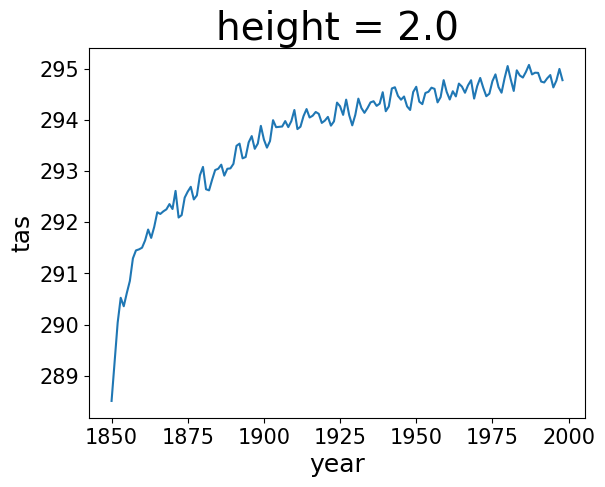

In [34]:
gtas.plot()

In [ ]:
yearme = gigi.groupby('time.year').mean().compute()
slopes, errs = regress_pattern_vectorized(yearme, gtas)

In [43]:
slopes

<xarray.Dataset> Size: 3MB
Dimensions:   (lat: 256, bnds: 2, lon: 512)
Coordinates:
  * lat       (lat) float64 2kB -89.46 -88.77 -88.07 ... 88.07 88.77 89.46
  * lon       (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
    height    float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 4kB -2.737e-15 1.466e-14 ... 2.737e-15
    lon_bnds  (lon, bnds) float64 8kB -1.069e-17 1.069e-17 ... 9.336e-15
    rlut      (lat, lon) float64 1MB 1.559 1.559 1.559 ... 4.794 4.793 4.792
    rsut      (lat, lon) float64 1MB -0.1402 -0.1401 -0.14 ... -8.117 -8.116
    tas       (lat, lon) float64 1MB 1.195 1.195 1.195 ... 4.333 4.333 4.334

In [54]:
ctl.plot_map_contour?

Signature:
ctl.plot_map_contour(
    data,
    lat=None,
    lon=None,
    filename=None,
    visualization='standard',
    central_lat_lon=None,
    cmap='RdBu_r',
    title=None,
    xlabel=None,
    ylabel=None,
    cb_label=None,
    cbar_range=None,
    plot_anomalies=False,
    n_color_levels=21,
    draw_contour_lines=False,
    n_lines=5,
    line_color='k',
    color_percentiles=(0, 100),
    figsize=(8, 6),
    bounding_lat=30,
    plot_margins=None,
    add_rectangles=None,
    draw_grid=True,
    plot_type='filled_contour',
    verbose=False,
    lw_contour=0.5,
    add_contour_field=None,
    add_vector_field=None,
    quiver_scale=None,
    add_hatching=None,
    hatch_styles=['', '', '...'],
    vec_every=2,
    add_contour_same_levels=False,
    add_contour_plot_anomalies=False,
    add_contour_lines_step=None,
    add_contour_range=None,
    extend_opt='both',
    color_norm=None,
    clevels=None,
    return_ax=False,
    add_contour_regrid_shape=30,
    vector_plot='

AttributeError: module 'xarray' has no attribute 'absval'

In [61]:
hatch = xr.where(errs['rlut'] > np.abs(slopes['rlut']), 1, 0)

In [63]:
np.sum(hatch)

<xarray.DataArray 'rlut' ()> Size: 8B
array(4186)
Coordinates:
    height   float64 8B 2.0

Adding cyclic point



<GeoAxes: >

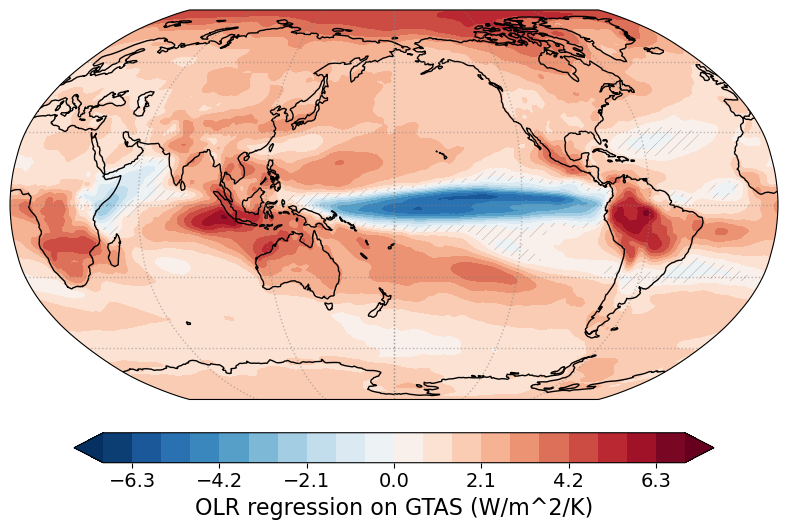

In [ ]:
hatch = xr.where(errs['rlut'] > np.abs(slopes['rlut']), 1, 0)
ctl.plot_map_contour(slopes['rlut'], cbar_range = (-7, 7), plot_anomalies = True, cb_label = r'OLR regression on GTAS (W/m^2/K)', central_lat_lon = (0, 180), visualization = 'Robinson', add_hatching = hatch, hatch_styles = ['', '', '///'])

Adding cyclic point



<GeoAxes: >

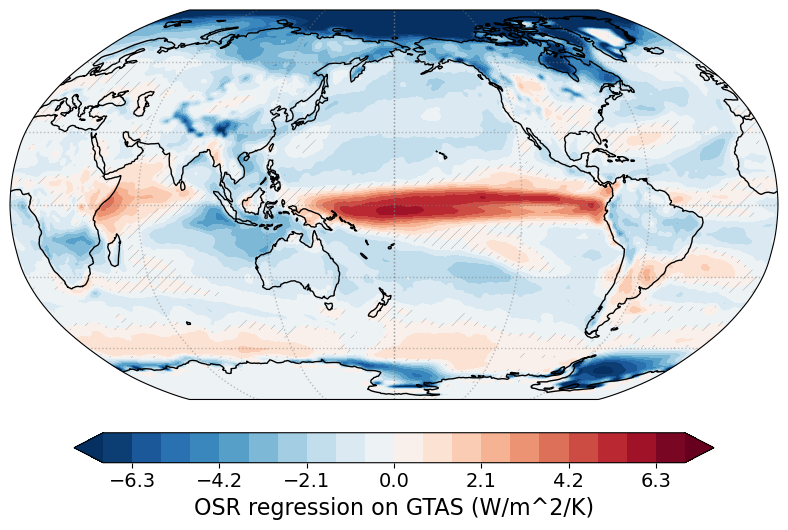

In [68]:

hatch = xr.where(errs['rsut'] > np.abs(slopes['rsut']), 1, 0)
ctl.plot_map_contour(slopes['rsut'], cbar_range = (-7, 7), plot_anomalies = True, cb_label = r'OSR regression on GTAS (W/m^2/K)', central_lat_lon = (0, 180), visualization = 'Robinson', add_hatching = hatch, hatch_styles = ['', '', '///'])

Adding cyclic point



<GeoAxes: >

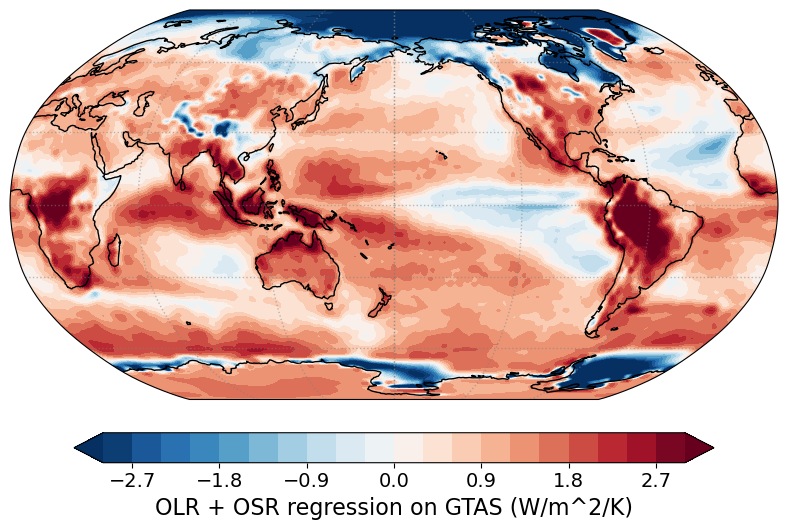

In [ ]:
ctl.plot_map_contour((slopes['rsut']+slopes['rlut']), cbar_range = (-3, 3), plot_anomalies = True, cb_label = r'OLR + OSR regression on GTAS (W/m^2/K)', central_lat_lon = (0, 180), visualization = 'Robinson', add_hatching = hatch, hatch_styles = ['', '', '///'])

In [40]:
slopegigi['rlut'] = slopes['rlut']

TypeError: Cannot assign a Dataset to a single key - only a DataArray or Variable object can be stored under a single key.

In [69]:
exp = 'c4c5'
okvars = 'rlut rsut tas'.split()
allfils = np.concatenate([glob.glob(fildict.format(exp, var, var)) for var in okvars])
gigi2 = xr.open_mfdataset(allfils)

In [71]:
gtas2 = ctl.global_mean(gigi2.tas.groupby('time.year').mean())
gtas2 = gtas2.compute()

In [72]:
yearme2 = gigi2.groupby('time.year').mean().compute()
slopes2, errs2 = regress_pattern_vectorized(yearme2, gtas2)

Adding cyclic point



<GeoAxes: >

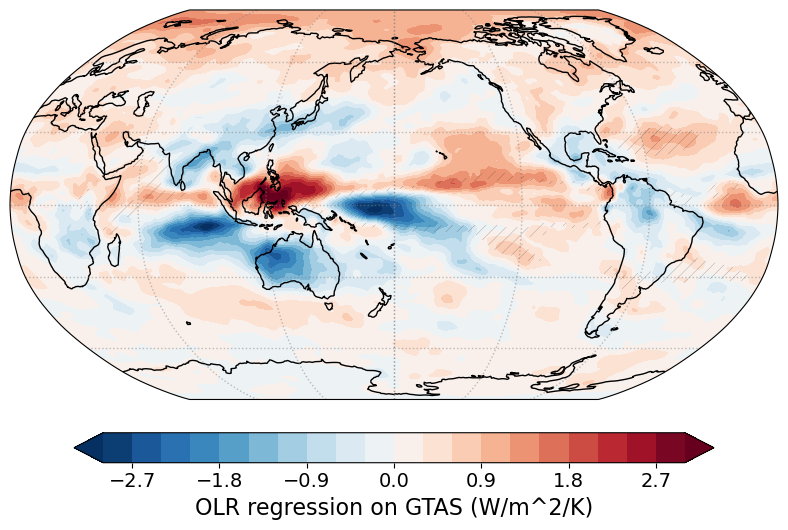

In [ ]:
var = 'rlut'
hatch = xr.where(errs[var] > np.abs(slopes[var]), 1, 0)
ctl.plot_map_contour(slopes2[var]-slopes[var], cbar_range = (-3, 3), plot_anomalies = True, cb_label = r'OLR regression on GTAS (W/m^2/K)', central_lat_lon = (0, 180), visualization = 'Robinson', add_hatching = hatch, hatch_styles = ['', '', '///'])

Adding cyclic point



<GeoAxes: >

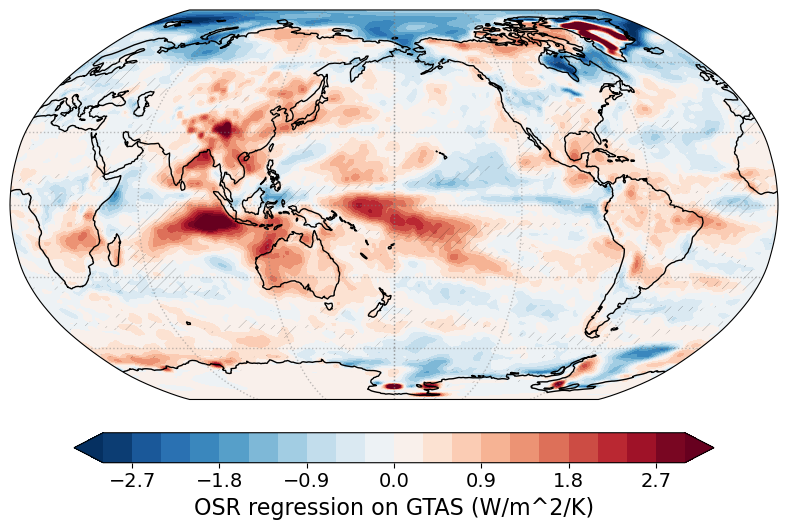

In [76]:
var = 'rsut'
hatch = xr.where(errs[var] > np.abs(slopes[var]), 1, 0)
ctl.plot_map_contour(slopes2[var]-slopes[var], cbar_range = (-3, 3), plot_anomalies = True, cb_label = r'OSR regression on GTAS (W/m^2/K)', central_lat_lon = (0, 180), visualization = 'Robinson', add_hatching = hatch, hatch_styles = ['', '', '///'])

Adding cyclic point



<GeoAxes: >

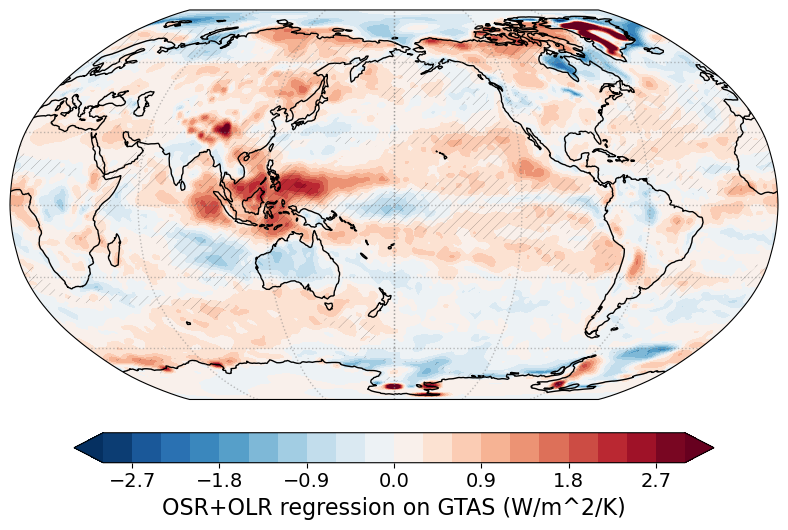

In [78]:
hatch = xr.where((errs['rlut']+errs['rsut']) > np.abs(slopes['rlut']+slopes['rsut']), 1, 0)
ctl.plot_map_contour(slopes2['rlut']-slopes['rlut']+slopes2['rsut']-slopes['rsut'], cbar_range = (-3, 3), plot_anomalies = True, cb_label = r'OSR+OLR regression on GTAS (W/m^2/K)', central_lat_lon = (0, 180), visualization = 'Robinson', add_hatching = hatch, hatch_styles = ['', '', '///'])